**Chapter 13 – Loading and Preprocessing Data with TensorFlow**

_This notebook contains all the sample code and solutions to the exercises in chapter 13._

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml3/blob/main/13_loading_and_preprocessing_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml3/blob/main/13_loading_and_preprocessing_data.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup

This project requires Python 3.7 or above:

In [124]:
from IPython.core.interactiveshell import InteractiveShell # make all output in ipython show, not just last line
InteractiveShell.ast_node_interactivity = "all"   # pretty print all cell's output and not just the last one
%matplotlib inline
import sklearn
sklearn.set_config(display="diagram")

In [125]:
import sys

assert sys.version_info >= (3, 7)

It also requires Scikit-Learn ≥ 1.0.1:

In [126]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

And TensorFlow ≥ 2.8:

In [127]:
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

# The tf.data API

In [128]:
import tensorflow as tf

X = tf.range(10)  # any data tensor
dataset = tf.data.Dataset.from_tensor_slices(X)
dataset

<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.int32, name=None)>

In [129]:
for item in dataset:
    print(item)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)


In [130]:
X_nested = {"a": ([1, 2, 3], [4, 5, 6]), "b": [7, 8, 9]}
dataset = tf.data.Dataset.from_tensor_slices(X_nested)
for item in dataset:
    print(item)

{'a': (<tf.Tensor: shape=(), dtype=int32, numpy=1>, <tf.Tensor: shape=(), dtype=int32, numpy=4>), 'b': <tf.Tensor: shape=(), dtype=int32, numpy=7>}
{'a': (<tf.Tensor: shape=(), dtype=int32, numpy=2>, <tf.Tensor: shape=(), dtype=int32, numpy=5>), 'b': <tf.Tensor: shape=(), dtype=int32, numpy=8>}
{'a': (<tf.Tensor: shape=(), dtype=int32, numpy=3>, <tf.Tensor: shape=(), dtype=int32, numpy=6>), 'b': <tf.Tensor: shape=(), dtype=int32, numpy=9>}


## Chaining Transformations

In [131]:
dataset = tf.data.Dataset.from_tensor_slices(tf.range(10))
dataset = dataset.repeat(3).batch(7)
for item in dataset:
    print(item)

tf.Tensor([0 1 2 3 4 5 6], shape=(7,), dtype=int32)
tf.Tensor([7 8 9 0 1 2 3], shape=(7,), dtype=int32)
tf.Tensor([4 5 6 7 8 9 0], shape=(7,), dtype=int32)
tf.Tensor([1 2 3 4 5 6 7], shape=(7,), dtype=int32)
tf.Tensor([8 9], shape=(2,), dtype=int32)


In [132]:
dataset = dataset.map(lambda x: x * 2)  # x is a batch
for item in dataset:
    print(item)

tf.Tensor([ 0  2  4  6  8 10 12], shape=(7,), dtype=int32)
tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int32)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int32)
tf.Tensor([ 2  4  6  8 10 12 14], shape=(7,), dtype=int32)
tf.Tensor([16 18], shape=(2,), dtype=int32)


In [133]:
dataset = dataset.filter(lambda x: tf.reduce_sum(x) > 50)
for item in dataset:
    print(item)

tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int32)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int32)
tf.Tensor([ 2  4  6  8 10 12 14], shape=(7,), dtype=int32)


In [134]:
for item in dataset.take(2):
    print(item)

tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int32)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int32)


## Shuffling the Data

In [135]:
dataset = tf.data.Dataset.range(10).repeat(2)
dataset = dataset.shuffle(buffer_size=4, seed=42).batch(7)
for item in dataset:
    print(item)

tf.Tensor([3 0 1 6 2 5 7], shape=(7,), dtype=int64)
tf.Tensor([8 4 1 9 4 2 3], shape=(7,), dtype=int64)
tf.Tensor([7 5 0 8 9 6], shape=(6,), dtype=int64)


### Interleaving lines from multiple files

Let's start by loading and preparing the California housing dataset. We first load it, then split it into a training set, a validation set and a test set:

In [136]:
# extra code – fetches, splits and normalizes the California housing dataset

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

For a very large dataset that does not fit in memory, you will typically want to split it into many files first, then have TensorFlow read these files in parallel. To demonstrate this, let's start by splitting the housing dataset and saving it to 20 CSV files:

In [137]:
# extra code – split the dataset into 20 parts and save it to CSV files

import numpy as np
from pathlib import Path

def save_to_csv_files(data, name_prefix, header=None, n_parts=10):
    housing_dir = Path() / "datasets" / "housing"
    housing_dir.mkdir(parents=True, exist_ok=True)
    filename_format = "my_{}_{:02d}.csv"

    filepaths = []
    m = len(data)
    chunks = np.array_split(np.arange(m), n_parts)
    for file_idx, row_indices in enumerate(chunks):
        part_csv = housing_dir / filename_format.format(name_prefix, file_idx)
        filepaths.append(str(part_csv))
        with open(part_csv, "w") as f:
            if header is not None:
                f.write(header)
                f.write("\n")
            for row_idx in row_indices:
                f.write(",".join([repr(col) for col in data[row_idx]]))
                f.write("\n")
    return filepaths

train_data = np.c_[X_train, y_train]
valid_data = np.c_[X_valid, y_valid]
test_data = np.c_[X_test, y_test]
header_cols = housing.feature_names + ["MedianHouseValue"]
header = ",".join(header_cols)

train_filepaths = save_to_csv_files(train_data, "train", header, n_parts=20)
valid_filepaths = save_to_csv_files(valid_data, "valid", header, n_parts=10)
test_filepaths = save_to_csv_files(test_data, "test", header, n_parts=10)

Okay, now let's take a peek at the first few lines of one of these CSV files:

In [138]:
print("".join(open(train_filepaths[0]).readlines()[:4]))

MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
3.5214,15.0,3.0499445061043287,1.106548279689234,1447.0,1.6059933407325193,37.63,-122.43,1.442
5.3275,5.0,6.490059642147117,0.9910536779324056,3464.0,3.4433399602385686,33.69,-117.39,1.687
3.1,29.0,7.5423728813559325,1.5915254237288134,1328.0,2.2508474576271187,38.44,-122.98,1.621



In [139]:
train_filepaths

['datasets\\housing\\my_train_00.csv',
 'datasets\\housing\\my_train_01.csv',
 'datasets\\housing\\my_train_02.csv',
 'datasets\\housing\\my_train_03.csv',
 'datasets\\housing\\my_train_04.csv',
 'datasets\\housing\\my_train_05.csv',
 'datasets\\housing\\my_train_06.csv',
 'datasets\\housing\\my_train_07.csv',
 'datasets\\housing\\my_train_08.csv',
 'datasets\\housing\\my_train_09.csv',
 'datasets\\housing\\my_train_10.csv',
 'datasets\\housing\\my_train_11.csv',
 'datasets\\housing\\my_train_12.csv',
 'datasets\\housing\\my_train_13.csv',
 'datasets\\housing\\my_train_14.csv',
 'datasets\\housing\\my_train_15.csv',
 'datasets\\housing\\my_train_16.csv',
 'datasets\\housing\\my_train_17.csv',
 'datasets\\housing\\my_train_18.csv',
 'datasets\\housing\\my_train_19.csv']

**Building an Input Pipeline**

In [140]:
filepath_dataset = tf.data.Dataset.list_files(train_filepaths, seed=42)

In [141]:
# extra code – shows that the file paths are shuffled
for filepath in filepath_dataset:
    print(filepath)

tf.Tensor(b'datasets\\housing\\my_train_15.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_08.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_03.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_01.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_10.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_05.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_19.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_16.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_02.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_09.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_00.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_07.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_12.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_04.csv', sh

In [142]:
n_readers = 5
dataset = filepath_dataset.interleave(
    lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
    cycle_length=n_readers)

In [143]:
for line in dataset.take(5):
    print(line)

tf.Tensor(b'4.6477,38.0,5.03728813559322,0.911864406779661,745.0,2.5254237288135593,32.64,-117.07,1.504', shape=(), dtype=string)
tf.Tensor(b'8.72,44.0,6.163179916317992,1.0460251046025104,668.0,2.794979079497908,34.2,-118.18,4.159', shape=(), dtype=string)
tf.Tensor(b'3.8456,35.0,5.461346633416459,0.9576059850374065,1154.0,2.8778054862842892,37.96,-122.05,1.598', shape=(), dtype=string)
tf.Tensor(b'3.3456,37.0,4.514084507042254,0.9084507042253521,458.0,3.2253521126760565,36.67,-121.7,2.526', shape=(), dtype=string)
tf.Tensor(b'3.6875,44.0,4.524475524475524,0.993006993006993,457.0,3.195804195804196,34.04,-118.15,1.625', shape=(), dtype=string)


## Preprocessing the Data

In [144]:
# extra code – compute the mean and standard deviation of each feature

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [145]:
X_mean, X_std = scaler.mean_, scaler.scale_  # extra code
n_inputs = 8

def parse_csv_line(line):
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defs)
    return tf.stack(fields[:-1]), tf.stack(fields[-1:])

def preprocess(line):
    x, y = parse_csv_line(line)
    return (x - X_mean) / X_std, y

In [146]:
preprocess(b'4.2083,44.0,5.3232,0.9171,846.0,2.3370,37.47,-122.2,2.782')

(<tf.Tensor: shape=(8,), dtype=float32, numpy=
 array([ 0.16579159,  1.216324  , -0.05204564, -0.39215982, -0.5277444 ,
        -0.2633488 ,  0.8543046 , -1.3072058 ], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.782], dtype=float32)>)

## Putting Everything Together + Prefetching

In [147]:
def csv_reader_dataset(filepaths, n_readers=5, n_read_threads=None,
                       n_parse_threads=5, shuffle_buffer_size=10_000, seed=42,
                       batch_size=32):
    dataset = tf.data.Dataset.list_files(filepaths, seed=seed)
    dataset = dataset.interleave(
        lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
        cycle_length=n_readers, num_parallel_calls=n_read_threads)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.shuffle(shuffle_buffer_size, seed=seed)
    return dataset.batch(batch_size).prefetch(1)

In [148]:
# extra code – show the first couple of batches produced by the dataset

example_set = csv_reader_dataset(train_filepaths, batch_size=3)
for X_batch, y_batch in example_set.take(2):
    print("X =", X_batch)
    print("y =", y_batch)
    print()

X = tf.Tensor(
[[-1.2345318   0.1879177  -0.18384208  0.19340092 -0.4273575   0.49201018
   1.0838584  -1.3871703 ]
 [-1.3836461  -0.7613805  -0.3076956  -0.07978077 -0.05045014  0.32237166
   0.50294524 -0.1027696 ]
 [-0.41767654 -0.91959685 -0.5876468  -0.01253252  2.441884   -0.30059808
  -0.68699217  0.521939  ]], shape=(3, 8), dtype=float32)
y = tf.Tensor(
[[0.804]
 [0.53 ]
 [1.745]], shape=(3, 1), dtype=float32)

X = tf.Tensor(
[[-0.58831733  0.02970133 -0.70486885  0.16348003  0.8174406  -0.29916376
  -0.70573175  0.6568782 ]
 [-1.3526396  -1.868895   -0.84703934 -0.0277291   0.58563805 -0.10333684
  -1.3756571   1.2116159 ]
 [-0.16590534  1.8491895  -0.24013318 -0.0694841  -0.141711   -0.41202638
   0.994848   -1.4321475 ]], shape=(3, 8), dtype=float32)
y = tf.Tensor(
[[2.045  ]
 [3.25   ]
 [5.00001]], shape=(3, 1), dtype=float32)



Here is a short description of each method in the `Dataset` class:

In [149]:
# extra code – list all methods of the tf.data.Dataset class
for m in dir(tf.data.Dataset):
    if not (m.startswith("_") or m.endswith("_")):
        func = getattr(tf.data.Dataset, m)
        if hasattr(func, "__doc__"):
            print("● {:21s}{}".format(m + "()", func.__doc__.split("\n")[0]))

● apply()              Applies a transformation function to this dataset.
● as_numpy_iterator()  Returns an iterator which converts all elements of the dataset to numpy.
● batch()              Combines consecutive elements of this dataset into batches.
● bucket_by_sequence_length()A transformation that buckets elements in a `Dataset` by length.
● cache()              Caches the elements in this dataset.
● cardinality()        Returns the cardinality of the dataset, if known.
● choose_from_datasets()Creates a dataset that deterministically chooses elements from `datasets`.
● concatenate()        Creates a `Dataset` by concatenating the given dataset with this dataset.
● element_spec()       The type specification of an element of this dataset.
● enumerate()          Enumerates the elements of this dataset.
● filter()             Filters this dataset according to `predicate`.
● flat_map()           Maps `map_func` across this dataset and flattens the result.
● from_generator()     Create

## Using the Dataset with Keras

In [150]:
train_set = csv_reader_dataset(train_filepaths)
valid_set = csv_reader_dataset(valid_filepaths)
test_set = csv_reader_dataset(test_filepaths)

In [151]:
# extra code – for reproducibility
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [152]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal",
                          input_shape=X_train.shape[1:]),
    tf.keras.layers.Dense(1),
])
model.compile(loss="mse", optimizer="sgd")
model.fit(train_set, validation_data=valid_set, epochs=5)

Epoch 1/5
363/363 [==============================] - 3s 6ms/step - loss: 1.0231 - val_loss: 2232.8931
Epoch 2/5
363/363 [==============================] - 2s 4ms/step - loss: 1.2354 - val_loss: 24.0907
Epoch 3/5
363/363 [==============================] - 1s 4ms/step - loss: 0.6587 - val_loss: 0.5340
Epoch 4/5
363/363 [==============================] - 1s 4ms/step - loss: 0.4393 - val_loss: 0.4384
Epoch 5/5
363/363 [==============================] - 1s 4ms/step - loss: 0.4317 - val_loss: 0.3900


In [153]:
test_mse = model.evaluate(test_set)
new_set = test_set.take(3)  # pretend we have 3 new samples
y_pred = model.predict(new_set)  # or you could just pass a NumPy array

3/3 [==============================] - 0s 13ms/step


In [154]:
# extra code – defines the optimizer and loss function for training
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
loss_fn = tf.keras.losses.mean_squared_error

n_epochs = 5
for epoch in range(n_epochs):
    for X_batch, y_batch in train_set:
        # extra code – perform one Gradient Descent step
        #              as explained in Chapter 12
        print("\rEpoch {}/{}".format(epoch + 1, n_epochs), end="")
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=2>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=3>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=4>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=5>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=6>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=7>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=8>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=9>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=10>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=11>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=12>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=13>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=14>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=15>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=16>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=17>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=18>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=19>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=20>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=21>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=22>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=23>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=24>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=25>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=26>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=27>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=28>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=29>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=30>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=31>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=32>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=33>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=34>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=35>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=36>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=37>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=38>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=39>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=40>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=41>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=42>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=43>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=44>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=45>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=46>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=47>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=48>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=49>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=50>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=51>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=52>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=53>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=54>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=55>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=56>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=57>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=58>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=59>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=60>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=61>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=62>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=63>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=64>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=65>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=66>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=67>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=68>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=69>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=70>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=71>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=72>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=73>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=74>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=75>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=76>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=77>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=78>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=79>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=80>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=81>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=82>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=83>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=84>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=85>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=86>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=87>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=88>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=89>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=90>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=91>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=92>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=93>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=94>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=95>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=96>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=97>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=98>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=99>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=100>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=101>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=102>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=103>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=104>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=105>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=106>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=107>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=108>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=109>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=110>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=111>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=112>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=113>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=114>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=115>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=116>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=117>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=118>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=119>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=120>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=121>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=122>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=123>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=124>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=125>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=126>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=127>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=128>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=129>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=130>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=131>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=132>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=133>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=134>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=135>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=136>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=137>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=138>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=139>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=140>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=141>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=142>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=143>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=144>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=145>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=146>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=147>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=148>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=149>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=150>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=151>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=152>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=153>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=154>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=155>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=156>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=157>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=158>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=159>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=160>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=161>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=162>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=163>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=164>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=165>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=166>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=167>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=168>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=169>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=170>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=171>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=172>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=173>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=174>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=175>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=176>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=177>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=178>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=179>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=180>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=181>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=182>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=183>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=184>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=185>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=186>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=187>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=188>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=189>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=190>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=191>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=192>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=193>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=194>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=195>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=196>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=197>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=198>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=199>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=200>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=201>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=202>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=203>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=204>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=205>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=206>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=207>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=208>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=209>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=210>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=211>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=212>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=213>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=214>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=215>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=216>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=217>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=218>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=219>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=220>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=221>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=222>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=223>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=224>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=225>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=226>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=227>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=228>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=229>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=230>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=231>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=232>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=233>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=234>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=235>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=236>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=237>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=238>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=239>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=240>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=241>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=242>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=243>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=244>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=245>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=246>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=247>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=248>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=249>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=250>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=251>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=252>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=253>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=254>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=255>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=256>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=257>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=258>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=259>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=260>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=261>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=262>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=263>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=264>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=265>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=266>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=267>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=268>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=269>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=270>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=271>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=272>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=273>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=274>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=275>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=276>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=277>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=278>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=279>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=280>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=281>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=282>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=283>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=284>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=285>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=286>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=287>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=288>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=289>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=290>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=291>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=292>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=293>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=294>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=295>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=296>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=297>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=298>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=299>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=300>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=301>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=302>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=303>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=304>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=305>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=306>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=307>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=308>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=309>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=310>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=311>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=312>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=313>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=314>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=315>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=316>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=317>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=318>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=319>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=320>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=321>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=322>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=323>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=324>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=325>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=326>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=327>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=328>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=329>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=330>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=331>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=332>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=333>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=334>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=335>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=336>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=337>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=338>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=339>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=340>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=341>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=342>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=343>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=344>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=345>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=346>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=347>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=348>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=349>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=350>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=351>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=352>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=353>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=354>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=355>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=356>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=357>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=358>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=359>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=360>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=361>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=362>

Epoch 1/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=363>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=364>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=365>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=366>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=367>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=368>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=369>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=370>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=371>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=372>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=373>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=374>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=375>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=376>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=377>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=378>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=379>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=380>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=381>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=382>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=383>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=384>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=385>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=386>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=387>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=388>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=389>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=390>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=391>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=392>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=393>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=394>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=395>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=396>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=397>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=398>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=399>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=400>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=401>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=402>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=403>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=404>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=405>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=406>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=407>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=408>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=409>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=410>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=411>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=412>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=413>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=414>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=415>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=416>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=417>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=418>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=419>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=420>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=421>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=422>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=423>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=424>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=425>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=426>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=427>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=428>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=429>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=430>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=431>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=432>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=433>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=434>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=435>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=436>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=437>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=438>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=439>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=440>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=441>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=442>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=443>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=444>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=445>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=446>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=447>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=448>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=449>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=450>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=451>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=452>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=453>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=454>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=455>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=456>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=457>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=458>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=459>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=460>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=461>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=462>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=463>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=464>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=465>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=466>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=467>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=468>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=469>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=470>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=471>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=472>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=473>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=474>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=475>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=476>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=477>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=478>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=479>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=480>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=481>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=482>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=483>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=484>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=485>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=486>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=487>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=488>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=489>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=490>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=491>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=492>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=493>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=494>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=495>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=496>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=497>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=498>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=499>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=500>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=501>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=502>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=503>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=504>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=505>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=506>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=507>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=508>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=509>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=510>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=511>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=512>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=513>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=514>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=515>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=516>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=517>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=518>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=519>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=520>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=521>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=522>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=523>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=524>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=525>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=526>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=527>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=528>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=529>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=530>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=531>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=532>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=533>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=534>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=535>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=536>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=537>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=538>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=539>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=540>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=541>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=542>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=543>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=544>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=545>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=546>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=547>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=548>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=549>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=550>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=551>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=552>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=553>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=554>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=555>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=556>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=557>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=558>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=559>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=560>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=561>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=562>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=563>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=564>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=565>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=566>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=567>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=568>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=569>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=570>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=571>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=572>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=573>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=574>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=575>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=576>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=577>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=578>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=579>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=580>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=581>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=582>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=583>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=584>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=585>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=586>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=587>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=588>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=589>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=590>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=591>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=592>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=593>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=594>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=595>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=596>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=597>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=598>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=599>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=600>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=601>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=602>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=603>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=604>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=605>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=606>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=607>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=608>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=609>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=610>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=611>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=612>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=613>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=614>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=615>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=616>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=617>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=618>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=619>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=620>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=621>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=622>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=623>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=624>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=625>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=626>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=627>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=628>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=629>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=630>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=631>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=632>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=633>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=634>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=635>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=636>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=637>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=638>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=639>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=640>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=641>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=642>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=643>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=644>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=645>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=646>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=647>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=648>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=649>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=650>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=651>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=652>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=653>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=654>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=655>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=656>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=657>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=658>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=659>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=660>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=661>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=662>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=663>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=664>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=665>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=666>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=667>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=668>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=669>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=670>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=671>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=672>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=673>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=674>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=675>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=676>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=677>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=678>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=679>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=680>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=681>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=682>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=683>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=684>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=685>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=686>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=687>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=688>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=689>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=690>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=691>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=692>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=693>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=694>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=695>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=696>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=697>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=698>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=699>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=700>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=701>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=702>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=703>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=704>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=705>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=706>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=707>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=708>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=709>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=710>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=711>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=712>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=713>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=714>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=715>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=716>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=717>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=718>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=719>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=720>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=721>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=722>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=723>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=724>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=725>

Epoch 2/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=726>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=727>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=728>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=729>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=730>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=731>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=732>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=733>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=734>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=735>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=736>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=737>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=738>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=739>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=740>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=741>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=742>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=743>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=744>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=745>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=746>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=747>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=748>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=749>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=750>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=751>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=752>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=753>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=754>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=755>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=756>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=757>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=758>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=759>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=760>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=761>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=762>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=763>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=764>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=765>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=766>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=767>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=768>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=769>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=770>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=771>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=772>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=773>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=774>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=775>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=776>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=777>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=778>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=779>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=780>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=781>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=782>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=783>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=784>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=785>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=786>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=787>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=788>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=789>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=790>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=791>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=792>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=793>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=794>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=795>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=796>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=797>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=798>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=799>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=800>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=801>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=802>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=803>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=804>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=805>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=806>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=807>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=808>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=809>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=810>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=811>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=812>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=813>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=814>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=815>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=816>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=817>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=818>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=819>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=820>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=821>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=822>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=823>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=824>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=825>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=826>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=827>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=828>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=829>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=830>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=831>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=832>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=833>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=834>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=835>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=836>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=837>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=838>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=839>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=840>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=841>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=842>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=843>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=844>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=845>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=846>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=847>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=848>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=849>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=850>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=851>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=852>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=853>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=854>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=855>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=856>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=857>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=858>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=859>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=860>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=861>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=862>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=863>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=864>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=865>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=866>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=867>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=868>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=869>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=870>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=871>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=872>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=873>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=874>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=875>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=876>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=877>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=878>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=879>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=880>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=881>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=882>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=883>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=884>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=885>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=886>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=887>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=888>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=889>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=890>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=891>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=892>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=893>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=894>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=895>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=896>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=897>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=898>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=899>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=900>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=901>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=902>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=903>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=904>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=905>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=906>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=907>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=908>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=909>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=910>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=911>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=912>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=913>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=914>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=915>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=916>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=917>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=918>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=919>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=920>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=921>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=922>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=923>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=924>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=925>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=926>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=927>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=928>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=929>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=930>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=931>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=932>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=933>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=934>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=935>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=936>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=937>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=938>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=939>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=940>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=941>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=942>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=943>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=944>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=945>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=946>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=947>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=948>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=949>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=950>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=951>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=952>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=953>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=954>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=955>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=956>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=957>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=958>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=959>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=960>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=961>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=962>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=963>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=964>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=965>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=966>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=967>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=968>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=969>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=970>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=971>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=972>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=973>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=974>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=975>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=976>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=977>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=978>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=979>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=980>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=981>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=982>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=983>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=984>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=985>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=986>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=987>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=988>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=989>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=990>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=991>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=992>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=993>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=994>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=995>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=996>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=997>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=998>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=999>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1000>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1001>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1002>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1003>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1004>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1005>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1006>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1007>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1008>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1009>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1010>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1011>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1012>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1013>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1014>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1015>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1016>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1017>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1018>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1019>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1020>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1021>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1022>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1023>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1024>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1025>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1026>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1027>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1028>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1029>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1030>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1031>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1032>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1033>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1034>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1035>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1036>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1037>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1038>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1039>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1040>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1041>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1042>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1043>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1044>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1045>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1046>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1047>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1048>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1049>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1050>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1051>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1052>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1053>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1054>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1055>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1056>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1057>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1058>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1059>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1060>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1061>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1062>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1063>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1064>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1065>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1066>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1067>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1068>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1069>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1070>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1071>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1072>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1073>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1074>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1075>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1076>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1077>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1078>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1079>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1080>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1081>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1082>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1083>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1084>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1085>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1086>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1087>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1088>

Epoch 3/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1089>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1090>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1091>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1092>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1093>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1094>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1095>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1096>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1097>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1098>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1099>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1100>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1101>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1102>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1103>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1104>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1105>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1106>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1107>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1108>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1109>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1110>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1111>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1112>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1113>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1114>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1115>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1116>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1117>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1118>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1119>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1120>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1121>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1122>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1123>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1124>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1125>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1126>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1127>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1128>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1129>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1130>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1131>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1132>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1133>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1134>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1135>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1136>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1137>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1138>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1139>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1140>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1141>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1142>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1143>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1144>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1145>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1146>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1147>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1148>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1149>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1150>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1151>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1152>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1153>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1154>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1155>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1156>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1157>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1158>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1159>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1160>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1161>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1162>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1163>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1164>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1165>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1166>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1167>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1168>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1169>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1170>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1171>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1172>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1173>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1174>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1175>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1176>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1177>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1178>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1179>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1180>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1181>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1182>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1183>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1184>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1185>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1186>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1187>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1188>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1189>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1190>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1191>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1192>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1193>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1194>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1195>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1196>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1197>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1198>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1199>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1200>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1201>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1202>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1203>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1204>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1205>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1206>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1207>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1208>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1209>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1210>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1211>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1212>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1213>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1214>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1215>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1216>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1217>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1218>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1219>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1220>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1221>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1222>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1223>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1224>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1225>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1226>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1227>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1228>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1229>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1230>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1231>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1232>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1233>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1234>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1235>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1236>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1237>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1238>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1239>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1240>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1241>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1242>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1243>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1244>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1245>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1246>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1247>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1248>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1249>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1250>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1251>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1252>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1253>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1254>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1255>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1256>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1257>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1258>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1259>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1260>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1261>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1262>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1263>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1264>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1265>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1266>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1267>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1268>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1269>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1270>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1271>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1272>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1273>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1274>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1275>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1276>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1277>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1278>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1279>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1280>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1281>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1282>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1283>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1284>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1285>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1286>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1287>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1288>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1289>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1290>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1291>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1292>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1293>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1294>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1295>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1296>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1297>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1298>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1299>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1300>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1301>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1302>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1303>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1304>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1305>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1306>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1307>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1308>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1309>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1310>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1311>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1312>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1313>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1314>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1315>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1316>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1317>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1318>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1319>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1320>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1321>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1322>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1323>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1324>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1325>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1326>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1327>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1328>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1329>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1330>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1331>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1332>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1333>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1334>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1335>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1336>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1337>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1338>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1339>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1340>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1341>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1342>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1343>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1344>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1345>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1346>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1347>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1348>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1349>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1350>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1351>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1352>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1353>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1354>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1355>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1356>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1357>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1358>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1359>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1360>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1361>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1362>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1363>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1364>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1365>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1366>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1367>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1368>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1369>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1370>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1371>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1372>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1373>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1374>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1375>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1376>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1377>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1378>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1379>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1380>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1381>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1382>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1383>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1384>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1385>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1386>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1387>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1388>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1389>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1390>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1391>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1392>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1393>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1394>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1395>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1396>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1397>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1398>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1399>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1400>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1401>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1402>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1403>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1404>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1405>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1406>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1407>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1408>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1409>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1410>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1411>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1412>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1413>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1414>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1415>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1416>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1417>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1418>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1419>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1420>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1421>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1422>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1423>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1424>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1425>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1426>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1427>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1428>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1429>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1430>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1431>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1432>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1433>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1434>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1435>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1436>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1437>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1438>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1439>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1440>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1441>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1442>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1443>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1444>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1445>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1446>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1447>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1448>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1449>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1450>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1451>

Epoch 4/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1452>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1453>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1454>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1455>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1456>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1457>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1458>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1459>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1460>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1461>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1462>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1463>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1464>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1465>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1466>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1467>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1468>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1469>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1470>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1471>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1472>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1473>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1474>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1475>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1476>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1477>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1478>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1479>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1480>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1481>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1482>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1483>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1484>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1485>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1486>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1487>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1488>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1489>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1490>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1491>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1492>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1493>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1494>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1495>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1496>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1497>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1498>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1499>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1500>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1501>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1502>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1503>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1504>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1505>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1506>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1507>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1508>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1509>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1510>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1511>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1512>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1513>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1514>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1515>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1516>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1517>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1518>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1519>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1520>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1521>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1522>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1523>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1524>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1525>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1526>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1527>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1528>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1529>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1530>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1531>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1532>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1533>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1534>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1535>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1536>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1537>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1538>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1539>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1540>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1541>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1542>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1543>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1544>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1545>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1546>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1547>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1548>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1549>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1550>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1551>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1552>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1553>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1554>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1555>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1556>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1557>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1558>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1559>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1560>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1561>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1562>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1563>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1564>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1565>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1566>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1567>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1568>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1569>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1570>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1571>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1572>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1573>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1574>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1575>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1576>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1577>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1578>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1579>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1580>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1581>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1582>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1583>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1584>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1585>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1586>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1587>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1588>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1589>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1590>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1591>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1592>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1593>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1594>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1595>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1596>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1597>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1598>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1599>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1600>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1601>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1602>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1603>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1604>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1605>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1606>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1607>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1608>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1609>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1610>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1611>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1612>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1613>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1614>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1615>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1616>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1617>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1618>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1619>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1620>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1621>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1622>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1623>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1624>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1625>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1626>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1627>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1628>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1629>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1630>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1631>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1632>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1633>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1634>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1635>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1636>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1637>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1638>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1639>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1640>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1641>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1642>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1643>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1644>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1645>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1646>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1647>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1648>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1649>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1650>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1651>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1652>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1653>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1654>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1655>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1656>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1657>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1658>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1659>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1660>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1661>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1662>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1663>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1664>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1665>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1666>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1667>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1668>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1669>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1670>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1671>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1672>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1673>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1674>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1675>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1676>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1677>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1678>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1679>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1680>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1681>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1682>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1683>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1684>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1685>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1686>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1687>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1688>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1689>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1690>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1691>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1692>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1693>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1694>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1695>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1696>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1697>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1698>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1699>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1700>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1701>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1702>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1703>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1704>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1705>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1706>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1707>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1708>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1709>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1710>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1711>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1712>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1713>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1714>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1715>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1716>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1717>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1718>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1719>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1720>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1721>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1722>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1723>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1724>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1725>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1726>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1727>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1728>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1729>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1730>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1731>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1732>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1733>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1734>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1735>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1736>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1737>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1738>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1739>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1740>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1741>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1742>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1743>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1744>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1745>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1746>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1747>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1748>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1749>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1750>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1751>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1752>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1753>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1754>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1755>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1756>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1757>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1758>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1759>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1760>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1761>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1762>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1763>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1764>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1765>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1766>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1767>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1768>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1769>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1770>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1771>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1772>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1773>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1774>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1775>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1776>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1777>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1778>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1779>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1780>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1781>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1782>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1783>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1784>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1785>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1786>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1787>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1788>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1789>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1790>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1791>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1792>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1793>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1794>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1795>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1796>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1797>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1798>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1799>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1800>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1801>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1802>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1803>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1804>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1805>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1806>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1807>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1808>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1809>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1810>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1811>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1812>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1813>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1814>

Epoch 5/5

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1815>

In [155]:
@tf.function
def train_one_epoch(model, optimizer, loss_fn, train_set):
    for X_batch, y_batch in train_set:
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
loss_fn = tf.keras.losses.mean_squared_error
for epoch in range(n_epochs):
    print("\rEpoch {}/{}".format(epoch + 1, n_epochs), end="")
    train_one_epoch(model, optimizer, loss_fn, train_set)

Epoch 5/5

# The TFRecord Format

A TFRecord file is just a list of binary records. You can create one using a `tf.io.TFRecordWriter`:

In [156]:
with tf.io.TFRecordWriter("my_data.tfrecord") as f:
    f.write(b"This is the first record")
    f.write(b"And this is the second record")

And you can read it using a `tf.data.TFRecordDataset`:

In [157]:
filepaths = ["my_data.tfrecord"]
dataset = tf.data.TFRecordDataset(filepaths)
for item in dataset:
    print(item)

tf.Tensor(b'This is the first record', shape=(), dtype=string)
tf.Tensor(b'And this is the second record', shape=(), dtype=string)


You can read multiple TFRecord files with just one `TFRecordDataset`. By default it will read them one at a time, but if you set `num_parallel_reads=3`, it will read 3 at a time in parallel and interleave their records:

In [158]:
# extra code – shows how to read multiple files in parallel and interleave them

filepaths = ["my_test_{}.tfrecord".format(i) for i in range(5)]
for i, filepath in enumerate(filepaths):
    with tf.io.TFRecordWriter(filepath) as f:
        for j in range(3):
            f.write("File {} record {}".format(i, j).encode("utf-8"))

dataset = tf.data.TFRecordDataset(filepaths, num_parallel_reads=3)
for item in dataset:
    print(item)

tf.Tensor(b'File 0 record 0', shape=(), dtype=string)
tf.Tensor(b'File 1 record 0', shape=(), dtype=string)
tf.Tensor(b'File 2 record 0', shape=(), dtype=string)
tf.Tensor(b'File 0 record 1', shape=(), dtype=string)
tf.Tensor(b'File 1 record 1', shape=(), dtype=string)
tf.Tensor(b'File 2 record 1', shape=(), dtype=string)
tf.Tensor(b'File 0 record 2', shape=(), dtype=string)
tf.Tensor(b'File 1 record 2', shape=(), dtype=string)
tf.Tensor(b'File 2 record 2', shape=(), dtype=string)
tf.Tensor(b'File 3 record 0', shape=(), dtype=string)
tf.Tensor(b'File 4 record 0', shape=(), dtype=string)
tf.Tensor(b'File 3 record 1', shape=(), dtype=string)
tf.Tensor(b'File 4 record 1', shape=(), dtype=string)
tf.Tensor(b'File 3 record 2', shape=(), dtype=string)
tf.Tensor(b'File 4 record 2', shape=(), dtype=string)


## Compressed TFRecord Files

In [159]:
options = tf.io.TFRecordOptions(compression_type="GZIP")
with tf.io.TFRecordWriter("my_compressed.tfrecord", options) as f:
    f.write(b"Compress, compress, compress!")

In [160]:
dataset = tf.data.TFRecordDataset(["my_compressed.tfrecord"],
                                  compression_type="GZIP")

In [161]:
# extra code – shows that the data is decompressed correctly
for item in dataset:
    print(item)

tf.Tensor(b'Compress, compress, compress!', shape=(), dtype=string)


## A Brief Introduction to Protocol Buffers

For this section you need to [install protobuf](https://developers.google.com/protocol-buffers/docs/downloads). In general you will not have to do so when using TensorFlow, as it comes with functions to create and parse protocol buffers of type `tf.train.Example`, which are generally sufficient. However, in this section we will learn about protocol buffers by creating our own simple protobuf definition, so we need the protobuf compiler (`protoc`): we will use it to compile the protobuf definition to a Python module that we can then use in our code.

First let's write a simple protobuf definition:

In [162]:
%%writefile person.proto
syntax = "proto3";
message Person {
    string name = 1;
    int32 id = 2;
    repeated string email = 3;
}

Overwriting person.proto


And let's compile it (the `--descriptor_set_out` and `--include_imports` options are only required for the `tf.io.decode_proto()` example below):

In [163]:
!dir .\protoc\bin

 Volume in drive C has no label.
 Volume Serial Number is AC47-8D45

 Directory of C:\Users\donda\OneDrive - University of Denver\Documents\DU\COMP4432summer23\handson-ml3-main\protoc\bin

06/09/2023  09:36 AM    <DIR>          .
06/09/2023  09:36 AM    <DIR>          ..
06/09/2023  09:36 AM        10,411,945 protoc.exe
               1 File(s)     10,411,945 bytes
               2 Dir(s)  706,747,170,816 bytes free


In [164]:
! .\protoc\bin\protoc person.proto --python_out=. --descriptor_set_out=person.desc --include_imports

In [165]:
!dir person*

 Volume in drive C has no label.
 Volume Serial Number is AC47-8D45

 Directory of C:\Users\donda\OneDrive - University of Denver\Documents\DU\COMP4432summer23\handson-ml3-main

07/23/2023  05:11 PM                92 person.desc
07/23/2023  05:09 PM               114 person.proto
07/23/2023  05:11 PM             1,029 person_pb2.py
               3 File(s)          1,235 bytes
               0 Dir(s)  706,746,007,552 bytes free


In [166]:
from person_pb2 import Person  # import the generated access class

person = Person(name="Al", id=123, email=["a@b.com"])  # create a Person
print(person)  # display the Person

name: "Al"
id: 123
email: "a@b.com"



In [167]:
person.name  # read a field

'Al'

In [168]:
person.name = "Alice"  # modify a field

In [169]:
person.email[0]  # repeated fields can be accessed like arrays

'a@b.com'

In [170]:
person.email.append("c@d.com")  # add an email address

In [171]:
serialized = person.SerializeToString()  # serialize person to a byte string
serialized

b'\n\x05Alice\x10{\x1a\x07a@b.com\x1a\x07c@d.com'

In [172]:
person2 = Person()  # create a new Person
person2.ParseFromString(serialized)  # parse the byte string (27 bytes long)

27

In [173]:
person == person2  # now they are equal

True

### Custom protobuf

In rare cases, you may want to parse a custom protobuf (like the one we just created) in TensorFlow. For this you can use the `tf.io.decode_proto()` function:

In [174]:
# extra code – shows how to use the tf.io.decode_proto() function

person_tf = tf.io.decode_proto(
    bytes=serialized,
    message_type="Person",
    field_names=["name", "id", "email"],
    output_types=[tf.string, tf.int32, tf.string],
    descriptor_source="person.desc")

person_tf.values

[<tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Alice'], dtype=object)>,
 <tf.Tensor: shape=(1,), dtype=int32, numpy=array([123])>,
 <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>]

For more details, see the [`tf.io.decode_proto()`](https://www.tensorflow.org/api_docs/python/tf/io/decode_proto) documentation.

## TensorFlow Protobufs

Here is the definition of the tf.train.Example protobuf:

```proto
syntax = "proto3";

message BytesList { repeated bytes value = 1; }
message FloatList { repeated float value = 1 [packed = true]; }
message Int64List { repeated int64 value = 1 [packed = true]; }
message Feature {
    oneof kind {
        BytesList bytes_list = 1;
        FloatList float_list = 2;
        Int64List int64_list = 3;
    }
};
message Features { map<string, Feature> feature = 1; };
message Example { Features features = 1; };
```

In [175]:
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Feature, Features, Example

person_example = Example(
    features=Features(
        feature={
            "name": Feature(bytes_list=BytesList(value=[b"Alice"])),
            "id": Feature(int64_list=Int64List(value=[123])),
            "emails": Feature(bytes_list=BytesList(value=[b"a@b.com",
                                                          b"c@d.com"]))
        }))

In [176]:
with tf.io.TFRecordWriter("my_contacts.tfrecord") as f:
    for _ in range(5):
        f.write(person_example.SerializeToString())

## Loading and Parsing Examples

In [177]:
feature_description = {
    "name": tf.io.FixedLenFeature([], tf.string, default_value=""),
    "id": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "emails": tf.io.VarLenFeature(tf.string),
}

def parse(serialized_example):
    return tf.io.parse_single_example(serialized_example, feature_description)

dataset = tf.data.TFRecordDataset(["my_contacts.tfrecord"]).map(parse)
for parsed_example in dataset:
    print(parsed_example)

{'emails': <tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x000001884784FFA0>, 'id': <tf.Tensor: shape=(), dtype=int64, numpy=123>, 'name': <tf.Tensor: shape=(), dtype=string, numpy=b'Alice'>}
{'emails': <tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x000001884784F9A0>, 'id': <tf.Tensor: shape=(), dtype=int64, numpy=123>, 'name': <tf.Tensor: shape=(), dtype=string, numpy=b'Alice'>}
{'emails': <tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x000001891B80F070>, 'id': <tf.Tensor: shape=(), dtype=int64, numpy=123>, 'name': <tf.Tensor: shape=(), dtype=string, numpy=b'Alice'>}
{'emails': <tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x000001891B87B250>, 'id': <tf.Tensor: shape=(), dtype=int64, numpy=123>, 'name': <tf.Tensor: shape=(), dtype=string, numpy=b'Alice'>}
{'emails': <tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x000001880C579910>, 'id': <tf.Tensor: shape=(), dtype=int64, numpy=123>, '

In [178]:
tf.sparse.to_dense(parsed_example["emails"], default_value=b"")

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>

In [179]:
parsed_example["emails"].values

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>

In [180]:
def parse(serialized_examples):
    return tf.io.parse_example(serialized_examples, feature_description)

dataset = tf.data.TFRecordDataset(["my_contacts.tfrecord"]).batch(2).map(parse)
for parsed_examples in dataset:
    print(parsed_examples)  # two examples at a time

{'emails': <tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x000001891B8C1100>, 'id': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([123, 123], dtype=int64)>, 'name': <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'Alice', b'Alice'], dtype=object)>}
{'emails': <tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x000001891B8C12B0>, 'id': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([123, 123], dtype=int64)>, 'name': <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'Alice', b'Alice'], dtype=object)>}
{'emails': <tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x000001891BDC6BB0>, 'id': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([123], dtype=int64)>, 'name': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Alice'], dtype=object)>}


In [181]:
parsed_examples

{'emails': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x1891bdc6bb0>,
 'id': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([123], dtype=int64)>,
 'name': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Alice'], dtype=object)>}

## Extra Material – Storing Images and Tensors in TFRecords

Let's load and display an example image:

(-0.5, 639.5, 426.5, -0.5)

Text(0.5, 1.0, 'Original Image')

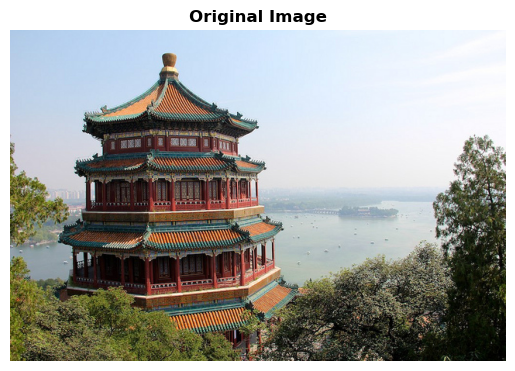

In [182]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_sample_images

img = load_sample_images()["images"][0]
plt.imshow(img)
plt.axis("off")
plt.title("Original Image")
plt.show()

Now let's create an `Example` protobuf containing the image encoded as JPEG:

In [183]:
data = tf.io.encode_jpeg(img)
example_with_image = Example(features=Features(feature={
    "image": Feature(bytes_list=BytesList(value=[data.numpy()]))}))
serialized_example = example_with_image.SerializeToString()
with tf.io.TFRecordWriter("my_image.tfrecord") as f:
    f.write(serialized_example)

Finally, let's create a tf.data pipeline that will read this TFRecord file, parse each `Example` protobuf (in this case just one), and parse and display the image that the example contains:

(-0.5, 639.5, 426.5, -0.5)

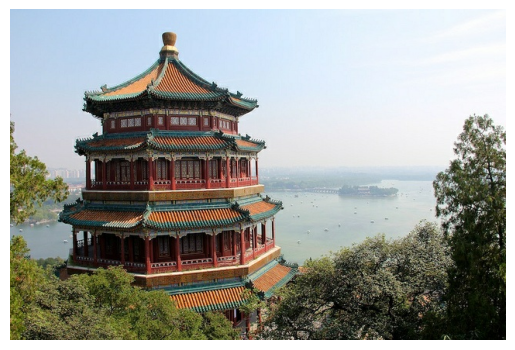

In [184]:
feature_description = { "image": tf.io.VarLenFeature(tf.string) }

def parse(serialized_example):
    example_with_image = tf.io.parse_single_example(serialized_example,
                                                    feature_description)
    return tf.io.decode_jpeg(example_with_image["image"].values[0])
    # or you can use tf.io.decode_image() instead

dataset = tf.data.TFRecordDataset("my_image.tfrecord").map(parse)
for image in dataset:
    plt.imshow(image)
    plt.axis("off")
    plt.show()

Or use `decode_image()` which supports BMP, GIF, JPEG and PNG formats:

Tensors can be serialized and parsed easily using `tf.io.serialize_tensor()` and `tf.io.parse_tensor()`:

In [185]:
tensor = tf.constant([[0., 1.], [2., 3.], [4., 5.]])
serialized = tf.io.serialize_tensor(tensor)
serialized

<tf.Tensor: shape=(), dtype=string, numpy=b'\x08\x01\x12\x08\x12\x02\x08\x03\x12\x02\x08\x02"\x18\x00\x00\x00\x00\x00\x00\x80?\x00\x00\x00@\x00\x00@@\x00\x00\x80@\x00\x00\xa0@'>

In [186]:
tf.io.parse_tensor(serialized, out_type=tf.float32)

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[0., 1.],
       [2., 3.],
       [4., 5.]], dtype=float32)>

In [187]:
sparse_tensor = parsed_example["emails"]
serialized_sparse = tf.io.serialize_sparse(sparse_tensor)
serialized_sparse

<tf.Tensor: shape=(3,), dtype=string, numpy=
array([b'\x08\t\x12\x08\x12\x02\x08\x02\x12\x02\x08\x01"\x10\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00',
       b'\x08\x07\x12\x04\x12\x02\x08\x02"\x10\x07\x07a@b.comc@d.com',
       b'\x08\t\x12\x04\x12\x02\x08\x01"\x08\x02\x00\x00\x00\x00\x00\x00\x00'],
      dtype=object)>

In [188]:
BytesList(value=serialized_sparse.numpy())

value: "\010\t\022\010\022\002\010\002\022\002\010\001\"\020\000\000\000\000\000\000\000\000\001\000\000\000\000\000\000\000"
value: "\010\007\022\004\022\002\010\002\"\020\007\007a@b.comc@d.com"
value: "\010\t\022\004\022\002\010\001\"\010\002\000\000\000\000\000\000\000"

## Handling Lists of Lists Using the `SequenceExample` Protobuf

```proto
syntax = "proto3";

message FeatureList { repeated Feature feature = 1; };
message FeatureLists { map<string, FeatureList> feature_list = 1; };
message SequenceExample {
    Features context = 1;
    FeatureLists feature_lists = 2;
};
```

In [189]:
from tensorflow.train import FeatureList, FeatureLists, SequenceExample

context = Features(feature={
    "author_id": Feature(int64_list=Int64List(value=[123])),
    "title": Feature(bytes_list=BytesList(value=[b"A", b"desert", b"place", b"."])),
    "pub_date": Feature(int64_list=Int64List(value=[1623, 12, 25]))
})

content = [["When", "shall", "we", "three", "meet", "again", "?"],
           ["In", "thunder", ",", "lightning", ",", "or", "in", "rain", "?"]]
comments = [["When", "the", "hurlyburly", "'s", "done", "."],
            ["When", "the", "battle", "'s", "lost", "and", "won", "."]]

def words_to_feature(words):
    return Feature(bytes_list=BytesList(value=[word.encode("utf-8")
                                               for word in words]))

content_features = [words_to_feature(sentence) for sentence in content]
comments_features = [words_to_feature(comment) for comment in comments]
            
sequence_example = SequenceExample(
    context=context,
    feature_lists=FeatureLists(feature_list={
        "content": FeatureList(feature=content_features),
        "comments": FeatureList(feature=comments_features)
    }))

In [190]:
sequence_example

context {
  feature {
    key: "author_id"
    value {
      int64_list {
        value: 123
      }
    }
  }
  feature {
    key: "pub_date"
    value {
      int64_list {
        value: 1623
        value: 12
        value: 25
      }
    }
  }
  feature {
    key: "title"
    value {
      bytes_list {
        value: "A"
        value: "desert"
        value: "place"
        value: "."
      }
    }
  }
}
feature_lists {
  feature_list {
    key: "comments"
    value {
      feature {
        bytes_list {
          value: "When"
          value: "the"
          value: "hurlyburly"
          value: "\'s"
          value: "done"
          value: "."
        }
      }
      feature {
        bytes_list {
          value: "When"
          value: "the"
          value: "battle"
          value: "\'s"
          value: "lost"
          value: "and"
          value: "won"
          value: "."
        }
      }
    }
  }
  feature_list {
    key: "content"
    value {
      feature {
      

In [191]:
serialized_sequence_example = sequence_example.SerializeToString()

In [192]:
context_feature_descriptions = {
    "author_id": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "title": tf.io.VarLenFeature(tf.string),
    "pub_date": tf.io.FixedLenFeature([3], tf.int64, default_value=[0, 0, 0]),
}
sequence_feature_descriptions = {
    "content": tf.io.VarLenFeature(tf.string),
    "comments": tf.io.VarLenFeature(tf.string),
}

In [193]:
parsed_context, parsed_feature_lists = tf.io.parse_single_sequence_example(
    serialized_sequence_example, context_feature_descriptions,
    sequence_feature_descriptions)
parsed_content = tf.RaggedTensor.from_sparse(parsed_feature_lists["content"])

In [194]:
parsed_context

{'title': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x188478554f0>,
 'author_id': <tf.Tensor: shape=(), dtype=int64, numpy=123>,
 'pub_date': <tf.Tensor: shape=(3,), dtype=int64, numpy=array([1623,   12,   25], dtype=int64)>}

In [195]:
parsed_context["title"].values

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'A', b'desert', b'place', b'.'], dtype=object)>

In [196]:
parsed_feature_lists

{'comments': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x1891b8a4be0>,
 'content': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x1891b8a47c0>}

In [197]:
print(tf.RaggedTensor.from_sparse(parsed_feature_lists["content"]))

<tf.RaggedTensor [[b'When', b'shall', b'we', b'three', b'meet', b'again', b'?'],
 [b'In', b'thunder', b',', b'lightning', b',', b'or', b'in', b'rain', b'?']]>


# Keras Preprocessing Layers

## The `Normalization` Layer

In [198]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
norm_layer = tf.keras.layers.Normalization()
model = tf.keras.models.Sequential([
    norm_layer,
    tf.keras.layers.Dense(1)
])
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=2e-3))
norm_layer.adapt(X_train)  # computes the mean and variance of every feature
model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=5)

Epoch 1/5
363/363 [==============================] - 1s 3ms/step - loss: 2.5392 - val_loss: 0.8704
Epoch 2/5
363/363 [==============================] - 1s 3ms/step - loss: 0.7115 - val_loss: 2.0136
Epoch 3/5
363/363 [==============================] - 1s 3ms/step - loss: 0.6208 - val_loss: 1.1908
Epoch 4/5
363/363 [==============================] - 1s 3ms/step - loss: 0.5960 - val_loss: 0.8041
Epoch 5/5
363/363 [==============================] - 1s 3ms/step - loss: 0.5827 - val_loss: 0.5508


In [199]:
norm_layer = tf.keras.layers.Normalization()
norm_layer.adapt(X_train)
X_train_scaled = norm_layer(X_train)
X_valid_scaled = norm_layer(X_valid)

In [200]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
model = tf.keras.models.Sequential([tf.keras.layers.Dense(1)])
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=2e-3))
model.fit(X_train_scaled, y_train, epochs=5,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
363/363 [==============================] - 2s 4ms/step - loss: 2.6077 - val_loss: 0.8290
Epoch 2/5
363/363 [==============================] - 1s 3ms/step - loss: 0.6577 - val_loss: 1.5706
Epoch 3/5
363/363 [==============================] - 1s 3ms/step - loss: 0.5663 - val_loss: 1.0292
Epoch 4/5
363/363 [==============================] - 1s 3ms/step - loss: 0.5531 - val_loss: 0.7290
Epoch 5/5
363/363 [==============================] - 1s 3ms/step - loss: 0.5491 - val_loss: 0.5183


In [201]:
final_model = tf.keras.Sequential([norm_layer, model])
X_new = X_test[:3]  # pretend we have a few new instances (unscaled)
y_pred = final_model(X_new)  # preprocesses the data and makes predictions

In [202]:
y_pred

<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
array([[0.8355098],
       [1.7057756],
       [2.5781472]], dtype=float32)>

In [203]:
# extra code – creates a dataset to demo applying the norm_layer using map()
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(5)

In [204]:
dataset = dataset.map(lambda X, y: (norm_layer(X), y))

In [205]:
list(dataset.take(1))  # extra code – shows the first batch

[(<tf.Tensor: shape=(5, 8), dtype=float32, numpy=
  array([[-0.19397885, -1.0778134 , -0.94338703,  0.0148516 ,  0.02073434,
          -0.5729169 ,  0.9292594 , -1.4221286 ],
         [ 0.7519829 , -1.8688954 ,  0.40547714, -0.23327833,  1.8614666 ,
           0.20516504, -0.9165495 ,  1.0966994 ],
         [-0.4146911 ,  0.02970134,  0.8180874 ,  1.056782  , -0.08786613,
          -0.29983333,  1.3087264 , -1.697002  ],
         [ 1.7188953 , -1.315138  ,  0.3266428 , -0.21955259, -0.337921  ,
          -0.11146676, -0.9821363 ,  0.94177276],
         [-0.962072  , -1.2360299 , -0.05625897, -0.03124549,  1.709061  ,
          -0.3025704 , -0.80411375,  1.326592  ]], dtype=float32)>,
  <tf.Tensor: shape=(5, 1), dtype=float64, numpy=
  array([[1.442],
         [1.687],
         [1.621],
         [2.621],
         [0.956]])>)]

In [206]:
class MyNormalization(tf.keras.layers.Layer):
    def adapt(self, X):
        self.mean_ = np.mean(X, axis=0, keepdims=True)
        self.std_ = np.std(X, axis=0, keepdims=True)

    def call(self, inputs):
        eps = tf.keras.backend.epsilon()  # a small smoothing term
        return (inputs - self.mean_) / (self.std_ + eps)

In [207]:
my_norm_layer = MyNormalization()
my_norm_layer.adapt(X_train)
X_train_scaled = my_norm_layer(X_train)

## The `Discretization` Layer

In [208]:
age = tf.constant([[10.], [93.], [57.], [18.], [37.], [5.]])
discretize_layer = tf.keras.layers.Discretization(bin_boundaries=[18., 50.])
age_categories = discretize_layer(age)
age_categories

<tf.Tensor: shape=(6, 1), dtype=int64, numpy=
array([[0],
       [2],
       [2],
       [1],
       [1],
       [0]], dtype=int64)>

In [209]:
discretize_layer = tf.keras.layers.Discretization(num_bins=3)
discretize_layer.adapt(age)
age_categories = discretize_layer(age)
age_categories

<tf.Tensor: shape=(6, 1), dtype=int64, numpy=
array([[1],
       [2],
       [2],
       [1],
       [2],
       [0]], dtype=int64)>

## The `CategoryEncoding` Layer

In [210]:
onehot_layer = tf.keras.layers.CategoryEncoding(num_tokens=3)
onehot_layer(age_categories)

<tf.Tensor: shape=(6, 3), dtype=float32, numpy=
array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)>

In [211]:
two_age_categories = np.array([[1, 0], [2, 2], [2, 0]])
onehot_layer(two_age_categories)

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[1., 1., 0.],
       [0., 0., 1.],
       [1., 0., 1.]], dtype=float32)>

In [212]:
onehot_layer = tf.keras.layers.CategoryEncoding(num_tokens=3, output_mode="count")
onehot_layer(two_age_categories)

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[1., 1., 0.],
       [0., 0., 2.],
       [1., 0., 1.]], dtype=float32)>

In [213]:
onehot_layer = tf.keras.layers.CategoryEncoding(num_tokens=3 + 3)
onehot_layer(two_age_categories + [0, 3])  # adds 3 to the second feature

<tf.Tensor: shape=(3, 6), dtype=float32, numpy=
array([[0., 1., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 1.],
       [0., 0., 1., 1., 0., 0.]], dtype=float32)>

In [214]:
# extra code – shows another way to one-hot encode each feature separately
onehot_layer = tf.keras.layers.CategoryEncoding(num_tokens=3,
                                                output_mode="one_hot")
tf.keras.layers.concatenate([onehot_layer(cat)
                             for cat in tf.transpose(two_age_categories)])

<tf.Tensor: shape=(3, 6), dtype=float32, numpy=
array([[0., 1., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 1.],
       [0., 0., 1., 1., 0., 0.]], dtype=float32)>

In [215]:
# extra code – shows another way to do this, using tf.one_hot() and Flatten
tf.keras.layers.Flatten()(tf.one_hot(two_age_categories, depth=3))

<tf.Tensor: shape=(3, 6), dtype=float32, numpy=
array([[0., 1., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 1.],
       [0., 0., 1., 1., 0., 0.]], dtype=float32)>

## The `StringLookup` Layer

In [216]:
cities = ["Auckland", "Paris", "Paris", "San Francisco"]
str_lookup_layer = tf.keras.layers.StringLookup()
str_lookup_layer.adapt(cities)
str_lookup_layer([["Paris"], ["Auckland"], ["Auckland"], ["Montreal"]])

<tf.Tensor: shape=(4, 1), dtype=int64, numpy=
array([[1],
       [3],
       [3],
       [0]], dtype=int64)>

In [217]:
str_lookup_layer = tf.keras.layers.StringLookup(num_oov_indices=5)
str_lookup_layer.adapt(cities)
str_lookup_layer([["Paris"], ["Auckland"], ["Foo"], ["Bar"], ["Baz"]])

<tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[5],
       [7],
       [4],
       [3],
       [4]], dtype=int64)>

In [218]:
str_lookup_layer = tf.keras.layers.StringLookup(output_mode="one_hot")
str_lookup_layer.adapt(cities)
str_lookup_layer([["Paris"], ["Auckland"], ["Auckland"], ["Montreal"]])

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.]], dtype=float32)>

In [219]:
# extra code – an example using the IntegerLookup layer
ids = [123, 456, 789]
int_lookup_layer = tf.keras.layers.IntegerLookup()
int_lookup_layer.adapt(ids)
int_lookup_layer([[123], [456], [123], [111]])

<tf.Tensor: shape=(4, 1), dtype=int64, numpy=
array([[3],
       [2],
       [3],
       [0]], dtype=int64)>

## The `Hashing` Layer

In [220]:
hashing_layer = tf.keras.layers.Hashing(num_bins=10)
hashing_layer([["Paris"], ["Tokyo"], ["Auckland"], ["Montreal"]])

<tf.Tensor: shape=(4, 1), dtype=int64, numpy=
array([[0],
       [1],
       [9],
       [1]], dtype=int64)>

## Encoding Categorical Features Using Embeddings

In [221]:
tf.random.set_seed(42)
embedding_layer = tf.keras.layers.Embedding(input_dim=5, output_dim=2)
embedding_layer(np.array([2, 4, 2]))

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[-0.0014685 , -0.03108091],
       [-0.0456486 ,  0.04637631],
       [-0.0014685 , -0.03108091]], dtype=float32)>

**Warning**: there's a bug in Keras 2.8.0 ([issue #16101](https://github.com/keras-team/keras/issues/16101)) which prevents using a `StringLookup` layer as the first layer of a `Sequential` model. Luckily, there's a simple workaround: just add an `InputLayer` as the first layer.

In [222]:
tf.random.set_seed(42)
ocean_prox = ["<1H OCEAN", "INLAND", "NEAR OCEAN", "NEAR BAY", "ISLAND"]
str_lookup_layer = tf.keras.layers.StringLookup()
str_lookup_layer.adapt(ocean_prox)
lookup_and_embed = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=[], dtype=tf.string),  # WORKAROUND
    str_lookup_layer,
    tf.keras.layers.Embedding(input_dim=str_lookup_layer.vocabulary_size(),
                              output_dim=2)
])
lookup_and_embed(np.array(["<1H OCEAN", "ISLAND", "<1H OCEAN"]))

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[-0.00261371,  0.01788596],
       [ 0.03737945,  0.04617938],
       [-0.00261371,  0.01788596]], dtype=float32)>

In [223]:
# extra code – set seeds and generates fake random data
# (feel free to load the real dataset if you prefer)
tf.random.set_seed(42)
np.random.seed(42)
X_train_num = np.random.rand(10_000, 8)
X_train_cat = np.random.choice(ocean_prox, size=10_000)
y_train = np.random.rand(10_000, 1)
X_valid_num = np.random.rand(2_000, 8)
X_valid_cat = np.random.choice(ocean_prox, size=2_000)
y_valid = np.random.rand(2_000, 1)

num_input = tf.keras.layers.Input(shape=[8], name="num")
cat_input = tf.keras.layers.Input(shape=[], dtype=tf.string, name="cat")
cat_embeddings = lookup_and_embed(cat_input) 
encoded_inputs = tf.keras.layers.concatenate([num_input, cat_embeddings])
outputs = tf.keras.layers.Dense(1)(encoded_inputs)
model = tf.keras.models.Model(inputs=[num_input, cat_input], outputs=[outputs])
model.compile(loss="mse", optimizer="sgd")
history = model.fit((X_train_num, X_train_cat), y_train, epochs=5,
                    validation_data=((X_valid_num, X_valid_cat), y_valid))

Epoch 1/5
313/313 [==============================] - 2s 4ms/step - loss: 0.2228 - val_loss: 0.1290
Epoch 2/5
313/313 [==============================] - 1s 3ms/step - loss: 0.1110 - val_loss: 0.1000
Epoch 3/5
313/313 [==============================] - 1s 3ms/step - loss: 0.0928 - val_loss: 0.0894
Epoch 4/5
313/313 [==============================] - 1s 3ms/step - loss: 0.0864 - val_loss: 0.0855
Epoch 5/5
313/313 [==============================] - 1s 3ms/step - loss: 0.0841 - val_loss: 0.0839


In [224]:
# extra code – shows that the model can also be trained using a tf.data.Dataset
train_set = tf.data.Dataset.from_tensor_slices(
    ((X_train_num, X_train_cat), y_train)).batch(32)
valid_set = tf.data.Dataset.from_tensor_slices(
    ((X_valid_num, X_valid_cat), y_valid)).batch(32)
history = model.fit(train_set, epochs=5,
                    validation_data=valid_set)

Epoch 1/5
313/313 [==============================] - 1s 4ms/step - loss: 0.0832 - val_loss: 0.0834
Epoch 2/5
313/313 [==============================] - 1s 4ms/step - loss: 0.0829 - val_loss: 0.0832
Epoch 3/5
313/313 [==============================] - 1s 4ms/step - loss: 0.0828 - val_loss: 0.0830
Epoch 4/5
313/313 [==============================] - 1s 3ms/step - loss: 0.0828 - val_loss: 0.0830
Epoch 5/5
313/313 [==============================] - 1s 3ms/step - loss: 0.0828 - val_loss: 0.0829


In [225]:
# extra code – shows that the dataset can contain dictionaries
train_set = tf.data.Dataset.from_tensor_slices(
    ({"num": X_train_num, "cat": X_train_cat}, y_train)).batch(32)
valid_set = tf.data.Dataset.from_tensor_slices(
    ({"num": X_valid_num, "cat": X_valid_cat}, y_valid)).batch(32)
history = model.fit(train_set, epochs=5, validation_data=valid_set)

Epoch 1/5
313/313 [==============================] - 1s 4ms/step - loss: 0.0828 - val_loss: 0.0829
Epoch 2/5
313/313 [==============================] - 1s 3ms/step - loss: 0.0828 - val_loss: 0.0829
Epoch 3/5
313/313 [==============================] - 1s 3ms/step - loss: 0.0828 - val_loss: 0.0829
Epoch 4/5
313/313 [==============================] - 1s 3ms/step - loss: 0.0828 - val_loss: 0.0829
Epoch 5/5
313/313 [==============================] - 1s 3ms/step - loss: 0.0828 - val_loss: 0.0829


## Text Preprocessing

In [226]:
train_data = ["To be", "!(to be)", "That's the question", "Be, be, be."]
text_vec_layer = tf.keras.layers.TextVectorization()
text_vec_layer.adapt(train_data)
text_vec_layer(["Be good!", "Question: be or be?"])

<tf.Tensor: shape=(2, 4), dtype=int64, numpy=
array([[2, 1, 0, 0],
       [6, 2, 1, 2]], dtype=int64)>

In [227]:
text_vec_layer = tf.keras.layers.TextVectorization(ragged=True)
text_vec_layer.adapt(train_data)
text_vec_layer(["Be good!", "Question: be or be?"])

<tf.RaggedTensor [[2, 1], [6, 2, 1, 2]]>

In [228]:
text_vec_layer = tf.keras.layers.TextVectorization(output_mode="tf_idf")
text_vec_layer.adapt(train_data)
text_vec_layer(["Be good!", "Question: be or be?"])

<tf.Tensor: shape=(2, 6), dtype=float32, numpy=
array([[0.96725637, 0.6931472 , 0.        , 0.        , 0.        ,
        0.        ],
       [0.96725637, 1.3862944 , 0.        , 0.        , 0.        ,
        1.0986123 ]], dtype=float32)>

In [229]:
2 * np.log(1 + 4 / (1 + 3))

1.3862943611198906

In [230]:
1 * np.log(1 + 4 / (1 + 1))

1.0986122886681098

# Using Pretrained Language Model Components

In [231]:
import tensorflow_hub as hub

hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim50/2")
sentence_embeddings = hub_layer(tf.constant(["To be", "Not to be"]))
sentence_embeddings.numpy().round(2)

array([[-0.25,  0.28,  0.01,  0.1 ,  0.14,  0.16,  0.25,  0.02,  0.07,
         0.13, -0.19,  0.06, -0.04, -0.07,  0.  , -0.08, -0.14, -0.16,
         0.02, -0.24,  0.16, -0.16, -0.03,  0.03, -0.14,  0.03, -0.09,
        -0.04, -0.14, -0.19,  0.07,  0.15,  0.18, -0.23, -0.07, -0.08,
         0.01, -0.01,  0.09,  0.14, -0.03,  0.03,  0.08,  0.1 , -0.01,
        -0.03, -0.07, -0.1 ,  0.05,  0.31],
       [-0.2 ,  0.2 , -0.08,  0.02,  0.19,  0.05,  0.22, -0.09,  0.02,
         0.19, -0.02, -0.14, -0.2 , -0.04,  0.01, -0.07, -0.22, -0.1 ,
         0.16, -0.44,  0.31, -0.1 ,  0.23,  0.15, -0.05,  0.15, -0.13,
        -0.04, -0.08, -0.16, -0.1 ,  0.13,  0.13, -0.18, -0.04,  0.03,
        -0.1 , -0.07,  0.07,  0.03, -0.08,  0.02,  0.05,  0.07, -0.14,
        -0.1 , -0.18, -0.13, -0.04,  0.15]], dtype=float32)

## Image Preprocessing Layers

In [232]:
from sklearn.datasets import load_sample_images

images = load_sample_images()["images"]
crop_image_layer = tf.keras.layers.CenterCrop(height=100, width=100)
cropped_images = crop_image_layer(images)

(-0.5, 639.5, 426.5, -0.5)

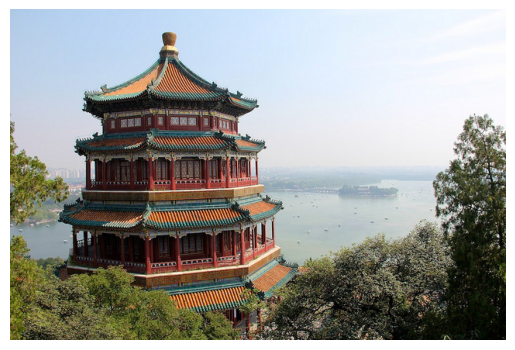

In [233]:
plt.imshow(images[0])
plt.axis("off")
plt.show()

(-0.5, 99.5, 99.5, -0.5)

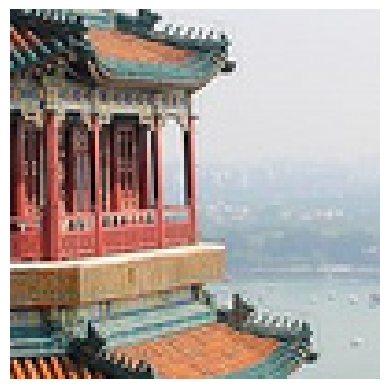

In [234]:
plt.imshow(cropped_images[0] / 255)
plt.axis("off")
plt.show()

# TensorFlow Datasets

In [235]:
import tensorflow_datasets as tfds

datasets = tfds.load(name="mnist")
mnist_train, mnist_test = datasets["train"], datasets["test"]

In [236]:
for batch in mnist_train.shuffle(10_000, seed=42).batch(32).prefetch(1):
    images = batch["image"]
    labels = batch["label"]
    # [...] do something with the images and labels

In [237]:
mnist_train = mnist_train.shuffle(10_000, seed=42).batch(32)
mnist_train = mnist_train.map(lambda items: (items["image"], items["label"]))
mnist_train = mnist_train.prefetch(1)

In [238]:
train_set, valid_set, test_set = tfds.load(
    name="mnist",
    split=["train[:90%]", "train[90%:]", "test"],
    as_supervised=True
)
train_set = train_set.shuffle(10_000, seed=42).batch(32).prefetch(1)
valid_set = valid_set.batch(32).cache()
test_set = test_set.batch(32).cache()
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=5)
test_loss, test_accuracy = model.evaluate(test_set)

Epoch 1/5
1688/1688 [==============================] - 10s 6ms/step - loss: 9.6037 - accuracy: 0.8366 - val_loss: 6.4947 - val_accuracy: 0.8783
Epoch 2/5
1688/1688 [==============================] - 9s 5ms/step - loss: 5.6272 - accuracy: 0.8789 - val_loss: 6.1280 - val_accuracy: 0.8713
Epoch 3/5
1688/1688 [==============================] - 10s 6ms/step - loss: 5.0791 - accuracy: 0.8843 - val_loss: 5.7936 - val_accuracy: 0.8743
Epoch 4/5
1688/1688 [==============================] - 9s 6ms/step - loss: 4.8319 - accuracy: 0.8860 - val_loss: 5.8557 - val_accuracy: 0.8705
Epoch 5/5
313/313 [==============================] - 1s 4ms/step - loss: 5.7830 - accuracy: 0.8713


# Exercises

## 1. to 8.
1. Ingesting a large dataset and preprocessing it efficiently can be a complex engineering challenge. The Data API makes it fairly simple. It offers many features, including loading data from various sources (such as text or binary files), reading data in parallel from multiple sources, transforming it, interleaving the records, shuffling the data, batching it, and prefetching it.
2. Splitting a large dataset into multiple files makes it possible to shuffle it at a coarse level before shuffling it at a finer level using a shuffling buffer. It also makes it possible to handle huge datasets that do not fit on a single machine. It's also simpler to manipulate thousands of small files rather than one huge file; for example, it's easier to split the data into multiple subsets. Lastly, if the data is split across multiple files spread across multiple servers, it is possible to download several files from different servers simultaneously, which improves the bandwidth usage.
3. You can use TensorBoard to visualize profiling data: if the GPU is not fully utilized then your input pipeline is likely to be the bottleneck. You can fix it by making sure it reads and preprocesses the data in multiple threads in parallel, and ensuring it prefetches a few batches. If this is insufficient to get your GPU to 100% usage during training, make sure your preprocessing code is optimized. You can also try saving the dataset into multiple TFRecord files, and if necessary perform some of the preprocessing ahead of time so that it does not need to be done on the fly during training (TF Transform can help with this). If necessary, use a machine with more CPU and RAM, and ensure that the GPU bandwidth is large enough.
4. A TFRecord file is composed of a sequence of arbitrary binary records: you can store absolutely any binary data you want in each record. However, in practice most TFRecord files contain sequences of serialized protocol buffers. This makes it possible to benefit from the advantages of protocol buffers, such as the fact that they can be read easily across multiple platforms and languages and their definition can be updated later in a backward-compatible way.
5. The `Example` protobuf format has the advantage that TensorFlow provides some operations to parse it (the `tf.io.parse`*`example()` functions) without you having to define your own format. It is sufficiently flexible to represent instances in most datasets. However, if it does not cover your use case, you can define your own protocol buffer, compile it using `protoc` (setting the `--descriptor_set_out` and `--include_imports` arguments to export the protobuf descriptor), and use the `tf.io.decode_proto()` function to parse the serialized protobufs (see the "Custom protobuf" section of the notebook for an example). It's more complicated, and it requires deploying the descriptor along with the model, but it can be done.
6. When using TFRecords, you will generally want to activate compression if the TFRecord files will need to be downloaded by the training script, as compression will make files smaller and thus reduce download time. But if the files are located on the same machine as the training script, it's usually preferable to leave compression off, to avoid wasting CPU for decompression.
7. Let's look at the pros and cons of each preprocessing option:
    * If you preprocess the data when creating the data files, the training script will run faster, since it will not have to perform preprocessing on the fly. In some cases, the preprocessed data will also be much smaller than the original data, so you can save some space and speed up downloads. It may also be helpful to materialize the preprocessed data, for example to inspect it or archive it. However, this approach has a few cons. First, it's not easy to experiment with various preprocessing logics if you need to generate a preprocessed dataset for each variant. Second, if you want to perform data augmentation, you have to materialize many variants of your dataset, which will use a large amount of disk space and take a lot of time to generate. Lastly, the trained model will expect preprocessed data, so you will have to add preprocessing code in your application before it calls the model. There's a risk of code duplication and preprocessing mismatch in this case.
    * If the data is preprocessed with the tf.data pipeline, it's much easier to tweak the preprocessing logic and apply data augmentation. Also, tf.data makes it easy to build highly efficient preprocessing pipelines (e.g., with multithreading and prefetching). However, preprocessing the data this way will slow down training. Moreover, each training instance will be preprocessed once per epoch rather than just once if the data was preprocessed when creating the data files. Well, unless the dataset fits in RAM and you can cache it using the dataset's `cache()` method. Lastly, the trained model will still expect preprocessed data. But if you use preprocessing layers in your tf.data pipeline to handle the preprocessing step, then you can just reuse these layers in your final model (adding them after training), to avoid code duplication and preprocessing mismatch.
    * If you add preprocessing layers to your model, you will only have to write the preprocessing code once for both training and inference. If your model needs to be deployed to many different platforms, you will not need to write the preprocessing code multiple times. Plus, you will not run the risk of using the wrong preprocessing logic for your model, since it will be part of the model. On the downside, preprocessing the data on the fly during training will slow things down, and each instance will be preprocessed once per epoch.
8. Let's look at how to encode categorical text features and text:
    * To encode a categorical feature that has a natural order, such as a movie rating (e.g., "bad," "average," "good"), the simplest option is to use ordinal encoding: sort the categories in their natural order and map each category to its rank (e.g., "bad" maps to 0, "average" maps to 1, and "good" maps to 2). However, most categorical features don't have such a natural order. For example, there's no natural order for professions or countries. In this case, you can use one-hot encoding, or embeddings if there are many categories. With Keras, the `StringLookup` layer can be used for ordinal encoding (using the default `output_mode="int"`), or one-hot encoding (using `output_mode="one_hot"`). It can also perform multi-hot encoding (using `output_mode="multi_hot"`) if you want to encode multiple categorical text features together, assuming they share the same categories and it doesn't matter which feature contributed which category. For trainable embeddings, you must first use the `StringLookup` layer to produce an ordinal encoding, then use the `Embedding` layer.
    * For text, the `TextVectorization` layer is easy to use and it can work well for simple tasks, or you can use TF Text for more advanced features. However, you'll often want to use pretrained language models, which you can obtain using tools like TF Hub or Hugging Face's Transformers library. These last two options are discussed in Chapter 16.

## 9.
### a.
_Exercise: Load the Fashion MNIST dataset (introduced in Chapter 10); split it into a training set, a validation set, and a test set; shuffle the training set; and save each dataset to multiple TFRecord files. Each record should be a serialized `Example` protobuf with two features: the serialized image (use `tf.io.serialize_tensor()` to serialize each image), and the label. Note: for large images, you could use `tf.io.encode_jpeg()` instead. This would save a lot of space, but it would lose a bit of image quality._

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [ ]:
tf.random.set_seed(42)
train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_set = train_set.shuffle(len(X_train), seed=42)
valid_set = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [ ]:
def create_example(image, label):
    image_data = tf.io.serialize_tensor(image)
    #image_data = tf.io.encode_jpeg(image[..., np.newaxis])
    return Example(
        features=Features(
            feature={
                "image": Feature(bytes_list=BytesList(value=[image_data.numpy()])),
                "label": Feature(int64_list=Int64List(value=[label])),
            }))

In [ ]:
for image, label in valid_set.take(1):
    print(create_example(image, label))

The following function saves a given dataset to a set of TFRecord files. The examples are written to the files in a round-robin fashion. To do this, we enumerate all the examples using the `dataset.enumerate()` method, and we compute `index % n_shards` to decide which file to write to. We use the standard `contextlib.ExitStack` class to make sure that all writers are properly closed whether or not an I/O error occurs while writing.

In [ ]:
from contextlib import ExitStack

def write_tfrecords(name, dataset, n_shards=10):
    paths = ["{}.tfrecord-{:05d}-of-{:05d}".format(name, index, n_shards)
             for index in range(n_shards)]
    with ExitStack() as stack:
        writers = [stack.enter_context(tf.io.TFRecordWriter(path))
                   for path in paths]
        for index, (image, label) in dataset.enumerate():
            shard = index % n_shards
            example = create_example(image, label)
            writers[shard].write(example.SerializeToString())
    return paths

In [ ]:
train_filepaths = write_tfrecords("my_fashion_mnist.train", train_set)
valid_filepaths = write_tfrecords("my_fashion_mnist.valid", valid_set)
test_filepaths = write_tfrecords("my_fashion_mnist.test", test_set)

### b.
_Exercise: Then use tf.data to create an efficient dataset for each set. Finally, use a Keras model to train these datasets, including a preprocessing layer to standardize each input feature. Try to make the input pipeline as efficient as possible, using TensorBoard to visualize profiling data._

In [ ]:
def preprocess(tfrecord):
    feature_descriptions = {
        "image": tf.io.FixedLenFeature([], tf.string, default_value=""),
        "label": tf.io.FixedLenFeature([], tf.int64, default_value=-1)
    }
    example = tf.io.parse_single_example(tfrecord, feature_descriptions)
    image = tf.io.parse_tensor(example["image"], out_type=tf.uint8)
    #image = tf.io.decode_jpeg(example["image"])
    image = tf.reshape(image, shape=[28, 28])
    return image, example["label"]

def mnist_dataset(filepaths, n_read_threads=5, shuffle_buffer_size=None,
                  n_parse_threads=5, batch_size=32, cache=True):
    dataset = tf.data.TFRecordDataset(filepaths,
                                      num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(1)

In [ ]:
train_set = mnist_dataset(train_filepaths, shuffle_buffer_size=60000)
valid_set = mnist_dataset(valid_filepaths)
test_set = mnist_dataset(test_filepaths)

In [ ]:
for X, y in train_set.take(1):
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(X[i].numpy(), cmap="binary")
        plt.axis("off")
        plt.title(str(y[i].numpy()))

In [ ]:
tf.random.set_seed(42)

standardization = tf.keras.layers.Normalization(input_shape=[28, 28])

sample_image_batches = train_set.take(100).map(lambda image, label: image)
sample_images = np.concatenate(list(sample_image_batches.as_numpy_iterator()),
                               axis=0).astype(np.float32)
standardization.adapt(sample_images)

model = tf.keras.Sequential([
    standardization,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="nadam", metrics=["accuracy"])

In [ ]:
from datetime import datetime

logs = Path() / "my_logs" / "run_" / datetime.now().strftime("%Y%m%d_%H%M%S")

tensorboard_cb = tf.keras.callbacks.TensorBoard(
    log_dir=logs, histogram_freq=1, profile_batch=10)

model.fit(train_set, epochs=5, validation_data=valid_set,
          callbacks=[tensorboard_cb])

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs

## 10.
_Exercise: In this exercise you will download a dataset, split it, create a `tf.data.Dataset` to load it and preprocess it efficiently, then build and train a binary classification model containing an `Embedding` layer._

### a.
_Exercise: Download the [Large Movie Review Dataset](https://homl.info/imdb), which contains 50,000 movies reviews from the [Internet Movie Database](https://imdb.com/). The data is organized in two directories, `train` and `test`, each containing a `pos` subdirectory with 12,500 positive reviews and a `neg` subdirectory with 12,500 negative reviews. Each review is stored in a separate text file. There are other files and folders (including preprocessed bag-of-words), but we will ignore them in this exercise._

In [ ]:
from pathlib import Path

root = "https://ai.stanford.edu/~amaas/data/sentiment/"
filename = "aclImdb_v1.tar.gz"
filepath = tf.keras.utils.get_file(filename, root + filename, extract=True,
                                   cache_dir=".")
path = Path(filepath).with_name("aclImdb")
path

Let's define a `tree()` function to view the structure of the `aclImdb` directory:

In [ ]:
def tree(path, level=0, indent=4, max_files=3):
    if level == 0:
        print(f"{path}/")
        level += 1
    sub_paths = sorted(path.iterdir())
    sub_dirs = [sub_path for sub_path in sub_paths if sub_path.is_dir()]
    filepaths = [sub_path for sub_path in sub_paths if not sub_path in sub_dirs]
    indent_str = " " * indent * level
    for sub_dir in sub_dirs:
        print(f"{indent_str}{sub_dir.name}/")
        tree(sub_dir,  level + 1, indent)
    for filepath in filepaths[:max_files]:
        print(f"{indent_str}{filepath.name}")
    if len(filepaths) > max_files:
        print(f"{indent_str}...")

In [ ]:
tree(path)

In [ ]:
def review_paths(dirpath):
    return [str(path) for path in dirpath.glob("*.txt")]

train_pos = review_paths(path / "train" / "pos")
train_neg = review_paths(path / "train" / "neg")
test_valid_pos = review_paths(path / "test" / "pos")
test_valid_neg = review_paths(path / "test" / "neg")

len(train_pos), len(train_neg), len(test_valid_pos), len(test_valid_neg)

### b.
_Exercise: Split the test set into a validation set (15,000) and a test set (10,000)._

In [ ]:
np.random.shuffle(test_valid_pos)

test_pos = test_valid_pos[:5000]
test_neg = test_valid_neg[:5000]
valid_pos = test_valid_pos[5000:]
valid_neg = test_valid_neg[5000:]

### c.
_Exercise: Use tf.data to create an efficient dataset for each set._

Since the dataset fits in memory, we can just load all the data using pure Python code and use `tf.data.Dataset.from_tensor_slices()`:

In [ ]:
def imdb_dataset(filepaths_positive, filepaths_negative):
    reviews = []
    labels = []
    for filepaths, label in ((filepaths_negative, 0), (filepaths_positive, 1)):
        for filepath in filepaths:
            with open(filepath) as review_file:
                reviews.append(review_file.read())
            labels.append(label)
    return tf.data.Dataset.from_tensor_slices(
        (tf.constant(reviews), tf.constant(labels)))

In [ ]:
for X, y in imdb_dataset(train_pos, train_neg).take(3):
    print(X)
    print(y)
    print()

In [ ]:
%timeit -r1 for X, y in imdb_dataset(train_pos, train_neg).repeat(10): pass

It takes about 17 seconds to load the dataset and go through it 10 times.

But let's pretend the dataset does not fit in memory, just to make things more interesting. Luckily, each review fits on just one line (they use `<br />` to indicate line breaks), so we can read the reviews using a `TextLineDataset`. If they didn't we would have to preprocess the input files (e.g., converting them to TFRecords). For very large datasets, it would make sense to use a tool like Apache Beam for that.

In [ ]:
def imdb_dataset(filepaths_positive, filepaths_negative, n_read_threads=5):
    dataset_neg = tf.data.TextLineDataset(filepaths_negative,
                                          num_parallel_reads=n_read_threads)
    dataset_neg = dataset_neg.map(lambda review: (review, 0))
    dataset_pos = tf.data.TextLineDataset(filepaths_positive,
                                          num_parallel_reads=n_read_threads)
    dataset_pos = dataset_pos.map(lambda review: (review, 1))
    return tf.data.Dataset.concatenate(dataset_pos, dataset_neg)

In [ ]:
%timeit -r1 for X, y in imdb_dataset(train_pos, train_neg).repeat(10): pass

Now it takes about 33 seconds to go through the dataset 10 times. That's much slower, essentially because the dataset is not cached in RAM, so it must be reloaded at each epoch. If you add `.cache()` just before `.repeat(10)`, you will see that this implementation will be about as fast as the previous one.

In [ ]:
%timeit -r1 for X, y in imdb_dataset(train_pos, train_neg).cache().repeat(10): pass

In [ ]:
batch_size = 32

train_set = imdb_dataset(train_pos, train_neg).shuffle(25000, seed=42)
train_set = train_set.batch(batch_size).prefetch(1)
valid_set = imdb_dataset(valid_pos, valid_neg).batch(batch_size).prefetch(1)
test_set = imdb_dataset(test_pos, test_neg).batch(batch_size).prefetch(1)

### d.
_Exercise: Create a binary classification model, using a `TextVectorization` layer to preprocess each review._

Let's create a `TextVectorization` layer and adapt it to the full IMDB training set (if the training set did not fit in RAM, we could just use a smaller sample of the training set by calling `train_set.take(500)`). Let's use TF-IDF for now.

In [ ]:
max_tokens = 1000
sample_reviews = train_set.map(lambda review, label: review)
text_vectorization = tf.keras.layers.TextVectorization(
    max_tokens=max_tokens, output_mode="tf_idf")
text_vectorization.adapt(sample_reviews)

Good! Now let's take a look at the first 10 words in the vocabulary:

In [ ]:
text_vectorization.get_vocabulary()[:10]

These are the most common words in the reviews.

We're ready to train the model!

In [ ]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    text_vectorization,
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])
model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.fit(train_set, epochs=5, validation_data=valid_set)

We get about 84.2% accuracy on the validation set after just the first epoch, but after that the model makes no significant progress. We will do better in Chapter 16. For now the point is just to perform efficient preprocessing using `tf.data` and Keras preprocessing layers.

### e.
_Exercise: Add an `Embedding` layer and compute the mean embedding for each review, multiplied by the square root of the number of words (see Chapter 16). This rescaled mean embedding can then be passed to the rest of your model._

To compute the mean embedding for each review, and multiply it by the square root of the number of words in that review, we will need a little function. For each sentence, this function needs to compute $M \times \sqrt N$, where $M$ is the mean of all the word embeddings in the sentence (excluding padding tokens), and $N$ is the number of words in the sentence (also excluding padding tokens). We can rewrite $M$ as $\dfrac{S}{N}$, where $S$ is the sum of all word embeddings (it does not matter whether or not we include the padding tokens in this sum, since their representation is a zero vector). So the function must return $M \times \sqrt N = \dfrac{S}{N} \times \sqrt N = \dfrac{S}{\sqrt N \times \sqrt N} \times \sqrt N= \dfrac{S}{\sqrt N}$.

In [ ]:
def compute_mean_embedding(inputs):
    not_pad = tf.math.count_nonzero(inputs, axis=-1)
    n_words = tf.math.count_nonzero(not_pad, axis=-1, keepdims=True)    
    sqrt_n_words = tf.math.sqrt(tf.cast(n_words, tf.float32))
    return tf.reduce_sum(inputs, axis=1) / sqrt_n_words

another_example = tf.constant([[[1., 2., 3.], [4., 5., 0.], [0., 0., 0.]],
                               [[6., 0., 0.], [0., 0., 0.], [0., 0., 0.]]])
compute_mean_embedding(another_example)

Let's check that this is correct. The first review contains 2 words (the last token is a zero vector, which represents the `<pad>` token). Let's compute the mean embedding for these 2 words, and multiply the result by the square root of 2:

In [ ]:
tf.reduce_mean(another_example[0:1, :2], axis=1) * tf.sqrt(2.)

Looks good! Now let's check the second review, which contains just one word (we ignore the two padding tokens):

In [ ]:
tf.reduce_mean(another_example[1:2, :1], axis=1) * tf.sqrt(1.)

Perfect. Now we're ready to train our final model. It's the same as before, except we replaced TF-IDF with ordinal encoding (`output_mode="int"`) followed by an `Embedding` layer, followed by a `Lambda` layer that calls the `compute_mean_embedding` layer:

In [ ]:
embedding_size = 20
tf.random.set_seed(42)

text_vectorization = tf.keras.layers.TextVectorization(
    max_tokens=max_tokens, output_mode="int")
text_vectorization.adapt(sample_reviews)

model = tf.keras.Sequential([
    text_vectorization,
    tf.keras.layers.Embedding(input_dim=max_tokens,
                              output_dim=embedding_size,
                              mask_zero=True),  # <pad> tokens => zero vectors
    tf.keras.layers.Lambda(compute_mean_embedding),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])

### f.
_Exercise: Train the model and see what accuracy you get. Try to optimize your pipelines to make training as fast as possible._

In [ ]:
model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.fit(train_set, epochs=5, validation_data=valid_set)

The model is just marginally better using embeddings (but we will do better in Chapter 16). The pipeline looks fast enough (we optimized it earlier).

### g.
_Exercise: Use TFDS to load the same dataset more easily: `tfds.load("imdb_reviews")`._

In [ ]:
import tensorflow_datasets as tfds

datasets = tfds.load(name="imdb_reviews")
train_set, test_set = datasets["train"], datasets["test"]

In [ ]:
for example in train_set.take(1):
    print(example["text"])
    print(example["label"])